# **SMS Spam Detection**

## *Import Dependencies*

In [1]:
import nltk
import pickle
import string
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

## *Load Data*

In [2]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [3]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
1849,ham,You got job in wipro:)you will get every thing...,NaN,NaN,NaN
3155,ham,Long time. You remember me today.,NaN,NaN,NaN
1161,ham,K. I will sent it again,NaN,NaN,NaN
483,ham,Thank you baby! I cant wait to taste the real ...,NaN,NaN,NaN
3632,ham,Hui xin is in da lib.,NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.drop(columns=df.columns[-3:], inplace=True)
df.sample(5)

,v1,v2
905,ham,Hey what's up charles sorry about the late reply.
3511,ham,Already one guy loving you:-.
3498,ham,I hope you arnt pissed off but id would really...
2015,ham,Just re read it and I have no shame but tell m...
3209,ham,"She said,'' do u mind if I go into the bedroom..."


In [7]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.sample(5)

,target,text
4333,ham,Boo what time u get out? U were supposed to ta...
432,spam,Congrats! Nokia 3650 video camera phone is you...
4447,ham,I sent them. Do you like?
3124,spam,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...
4029,ham,"Cool, I'll text you in a few"


In [8]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [10]:
df.duplicated().sum()

403

In [11]:
df = df.drop_duplicates(keep='first')

In [12]:
print(df.duplicated().sum(), df.shape)

0 (5169, 2)


## *Exploratory Data Analysis (EDA)*

In [13]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

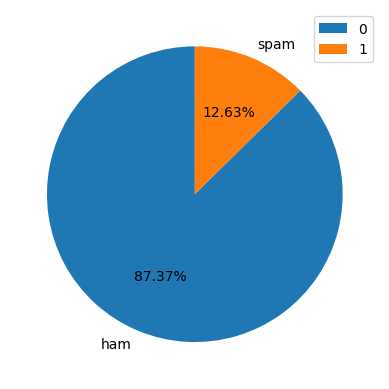

In [14]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f%%", startangle=90)
plt.legend('01')

In [15]:
df['num_chars'] = df['text'].apply(len)
df.head()

,target,text,num_chars
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [16]:
df['num_words'] = df['text'].apply(lambda x : len(nltk.word_tokenize(x)))
df.head()

,target,text,num_chars,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [17]:
df['num_sentences'] = df['text'].apply(lambda x : len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_chars,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [18]:
df[['num_chars', 'num_words', 'num_sentences']].describe()

,num_chars,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [19]:
# ham
df[df['target'] == 0][['num_chars', 'num_words', 'num_sentences']].describe()

,num_chars,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [20]:
# spam
df[df['target'] == 1][['num_chars', 'num_words', 'num_sentences']].describe()

,num_chars,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_chars', ylabel='Count'>

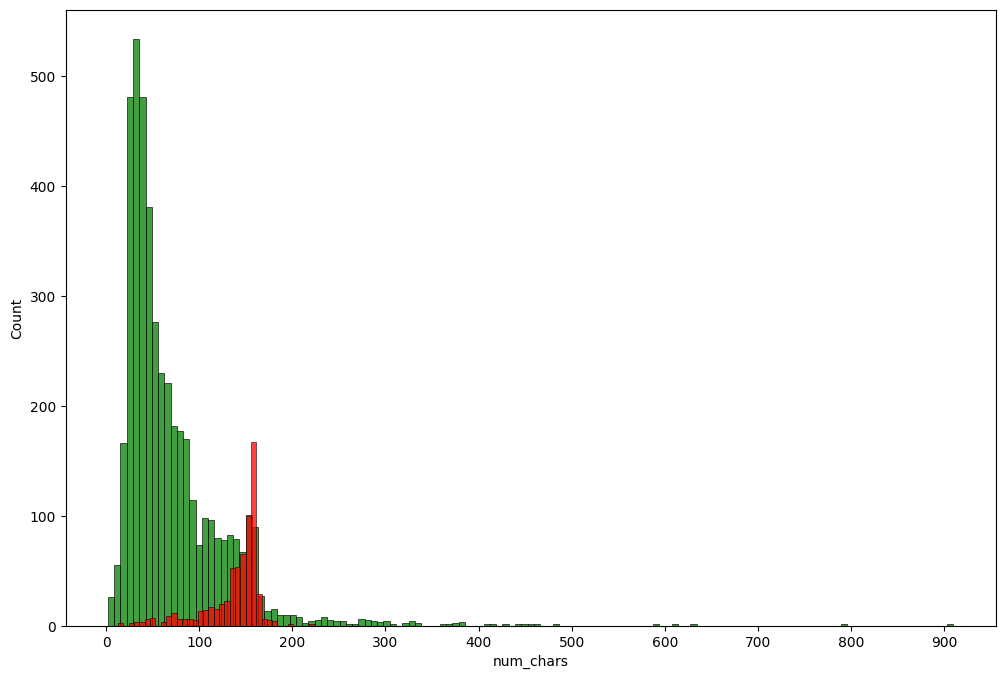

In [21]:
plt.figure(figsize=(12, 8))
plt.xticks(range(0, 901, 100))
sns.histplot(df[df['target'] == 0]['num_chars'], color='green')
sns.histplot(df[df['target'] == 1]['num_chars'], color='red')

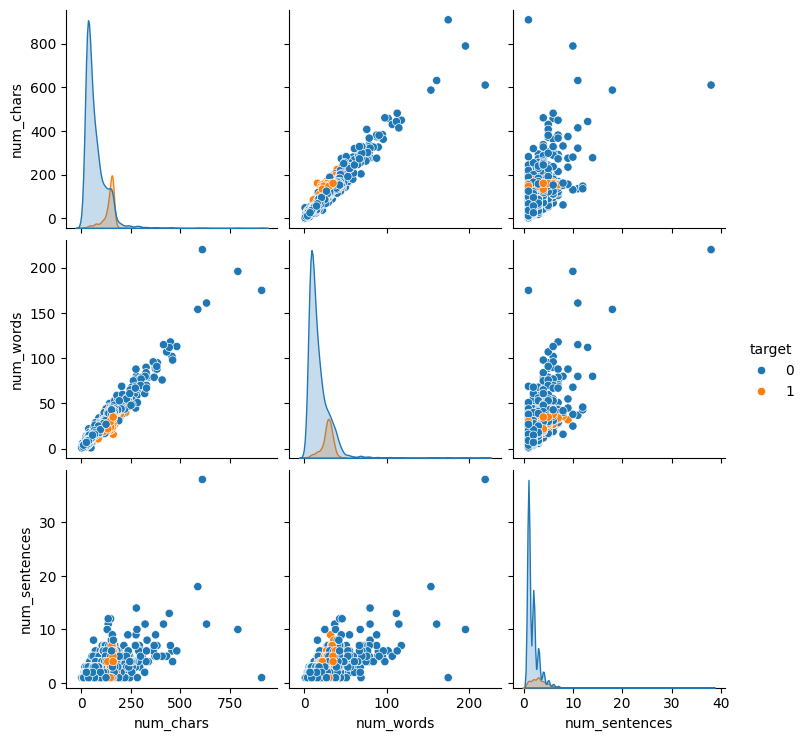

In [22]:
sns.pairplot(df, hue='target')

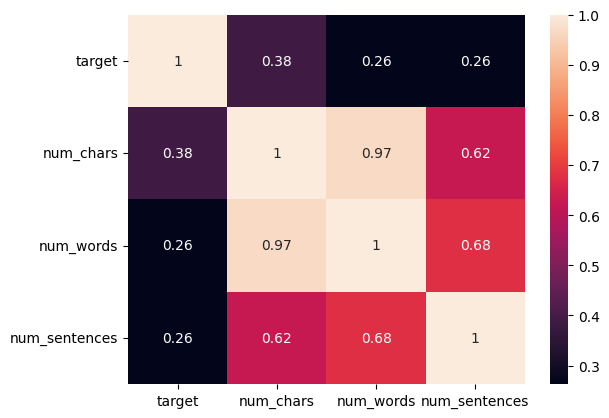

In [23]:
sns.heatmap(df.select_dtypes(include=['int32', 'int64']).corr(), annot=True)
plt.show()

## *Data PreProcessing*

In [24]:
punctuations = string.punctuation
stop_words = stopwords.words('english')
stemmer = PorterStemmer()

In [25]:
def preprocess_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    word_list = []
    for word in text:
        if word.isalnum() and word not in stop_words and word not in punctuations:
            word_list.append(word)
            
    text = " ".join(stemmer.stem(word) for word in word_list)
    
    return text

In [26]:
df['clean_text'] = df['text'].apply(preprocess_text)

In [27]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

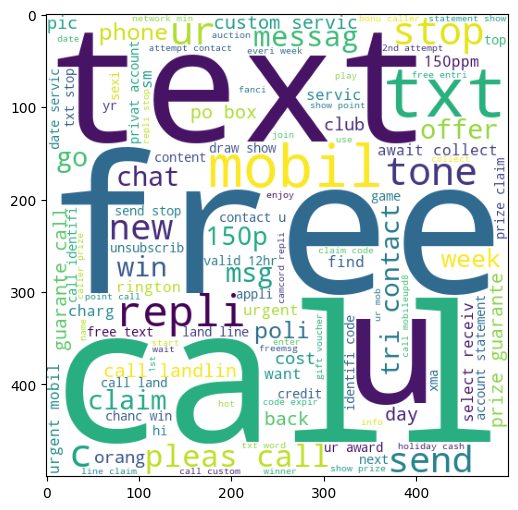

In [28]:
spam_wc = wc.generate(df[df['target'] == 1]['clean_text'].str.cat(sep=" "))
plt.figure(figsize=(16, 6))
plt.imshow(spam_wc)

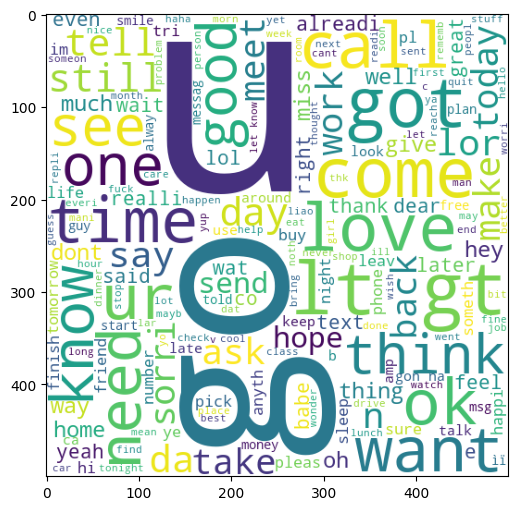

In [29]:
ham_wc = wc.generate(df[df['target'] == 0]['clean_text'].str.cat(sep=" "))
plt.figure(figsize=(16, 6))
plt.imshow(ham_wc)

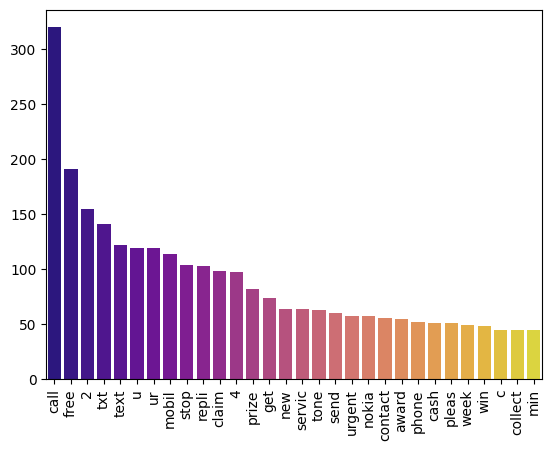

In [30]:
spam_corpus = []
for text in df[df['target'] == 1]['clean_text'].tolist():
    for word in text.split():
        spam_corpus.append(word)
        
most_common_elements = Counter(spam_corpus).most_common(30)
elements, counts = zip(*most_common_elements)

sns.barplot(x=list(elements), y=list(counts), hue=list(elements), palette="plasma", dodge=False)
plt.xticks(rotation="vertical")
plt.show()

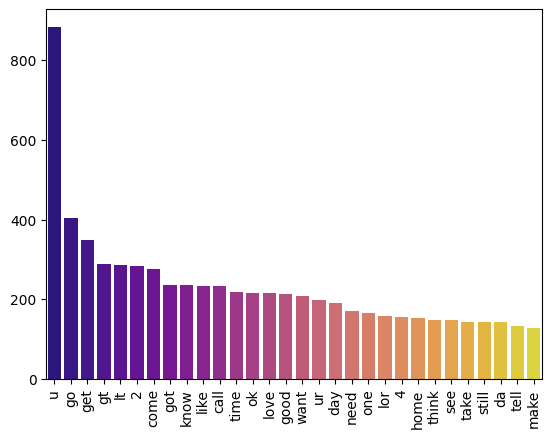

In [31]:
ham_corpus = []
for text in df[df['target'] == 0]['clean_text'].tolist():
    for word in text.split():
        ham_corpus.append(word)
        
most_common_elements = Counter(ham_corpus).most_common(30)
elements, counts = zip(*most_common_elements)

sns.barplot(x=list(elements), y=list(counts), hue=list(elements), palette="plasma", dodge=False)
plt.xticks(rotation="vertical")
plt.show()

## *Model Training*

In [32]:
tf_idf = TfidfVectorizer(max_features=3000)

In [33]:
X = tf_idf.fit_transform(df['clean_text']).toarray()

In [34]:
X.shape

(5169, 3000)

In [35]:
y = df['target'].values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

In [37]:
mnb = MultinomialNB()

In [38]:
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

## *Model Evaluation*

In [39]:
accuracy_score(y_test, y_pred)

0.9738878143133463

In [40]:
precision_score(y_test, y_pred)

1.0

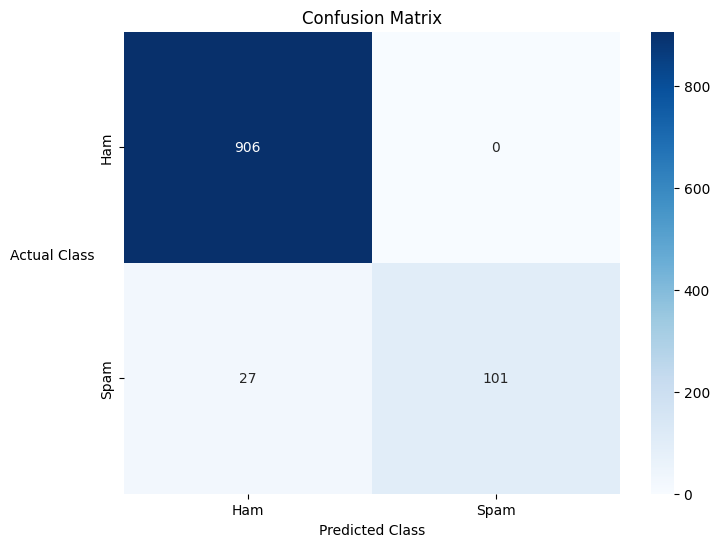

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class', rotation=0, ha='right')
plt.title('Confusion Matrix')
plt.show()

## *Save Model and Vectorizer*

In [42]:
pickle.dump(tf_idf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))